# Autoencoder for time series

## Notebook settings

In [1]:
%config IPCompleter.greedy=True
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
dataset_name = 'TwoLeadECG'
data_directory = '../data/UCRArchive_2018'
checkpoints_directory = 'checkpoints'

## Get data and divide in training and test set

In [3]:
import numpy as np

In [4]:
# %load -s loadData ../scripts/dataUtilities.py 
def loadData(direc, dataset, perm=True, ratio_train=0.8):
    datadir = direc + '/' + dataset + '/' + dataset
    data_train = np.genfromtxt(datadir + '_TRAIN.tsv', delimiter='\t')
    data_test_val = np.genfromtxt(datadir + '_TEST.tsv', delimiter='\t')
    data = np.concatenate((data_train, data_test_val), axis=0)

    N, D = data.shape
    ind_cut = int(ratio_train * N)
    if perm:
        ind = np.random.permutation(N)
    else:
        ind = range(0, N)
    return data[ind[:ind_cut], 1:], data[ind[ind_cut:], 1:], data[ind[:ind_cut], 0], data[ind[ind_cut:], 0]


In [5]:
dataTrain, dataTest, labelsTrain, labelsTest = loadData(data_directory, dataset_name)

# Data Profiling

In [6]:
import pandas as pd

In [7]:
# Building again the dataset
all_data = np.concatenate((dataTrain, dataTest))
all_labels = np.concatenate((labelsTrain, labelsTest)).reshape(-1, 1)
all_dataset = np.concatenate((all_labels, all_data), axis=1)

pd.DataFrame(all_data).plot(legend=False, title="All data");
all_dataset_df = pd.DataFrame(all_dataset)
all_dataset_df.head()
all_dataset_df.describe()
all_dataset_df.isnull().sum().sum()
all_dataset_df.groupby([0]).count()

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,1.0,-0.019677,-0.005523,-0.047984,-0.033830,0.079397,0.150165,0.192625,0.334159,0.291699,...,0.504000,0.419080,0.235085,0.164318,0.065244,-0.005523,-0.005523,-0.090444,-0.147058,-0.161211
1,1.0,0.271003,0.259214,0.247425,0.247425,0.259214,0.294581,0.341737,0.365315,0.424260,...,0.966555,0.848665,0.683619,0.553939,0.400682,0.271003,0.117746,0.011645,-0.082667,-0.176979
2,2.0,-0.793181,-0.761134,-0.745110,-0.713062,-0.697038,-0.632943,-0.584871,-0.520776,-0.504752,...,1.257873,1.193778,1.113659,0.985468,0.889324,0.793181,0.745110,0.648967,0.568847,0.536799
3,1.0,0.956258,-0.144062,-0.131998,-0.156126,-0.144062,-0.156126,-0.095806,-0.107870,-0.047551,...,1.327736,1.231224,1.122649,1.014074,0.893435,0.748668,0.615965,0.483262,0.410878,0.302303
4,2.0,0.368079,0.387365,0.387365,0.348793,0.329508,0.445223,0.406651,0.522367,0.522367,...,0.599511,0.483795,0.310222,0.175220,0.098076,-0.017640,-0.133355,-0.191213,-0.210499,-0.306929


,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
count,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,...,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000
mean,1.500000,0.211893,-0.013549,-0.000788,0.019547,0.051079,0.088293,0.124337,0.147471,0.165865,...,0.880844,0.775091,0.664715,0.556863,0.453974,0.356862,0.271545,0.198271,0.135982,0.082543
std,0.500215,0.596104,0.224209,0.221357,0.223314,0.225537,0.233421,0.228625,0.220851,0.208467,...,0.304274,0.316589,0.321427,0.318331,0.306637,0.291679,0.276192,0.258004,0.245691,0.234706
min,1.000000,-1.094231,-1.045439,-0.964121,-0.947857,-0.899066,-0.785220,-0.931593,-0.931593,-0.817747,...,-0.180272,-0.324590,-0.510142,-0.716310,-0.860628,-0.860628,-1.004946,-1.108030,-1.334816,-1.314199
25%,1.000000,-0.130237,-0.152992,-0.138321,-0.117577,-0.095590,-0.068017,-0.026761,0.004685,0.040486,...,0.681907,0.550100,0.434948,0.327693,0.242832,0.160489,0.087513,0.024878,-0.024896,-0.067974
50%,1.500000,0.023087,-0.023008,-0.014385,0.008114,0.042185,0.084113,0.129008,0.151925,0.159879,...,0.914313,0.799287,0.677635,0.557701,0.447223,0.349904,0.264846,0.194350,0.137010,0.087293
75%,2.000000,0.243818,0.111869,0.122944,0.153416,0.184059,0.225326,0.255602,0.288778,0.294791,...,1.116897,1.013685,0.900652,0.783519,0.670549,0.560454,0.466957,0.378577,0.296333,0.234009
max,2.000000,1.929262,0.933039,0.824085,0.920655,0.896512,0.920655,0.943657,1.056740,0.953655,...,1.539232,1.491148,1.423068,1.377346,1.251609,1.137304,1.011568,0.961909,0.965297,0.905599


0

,1,2,3,4,5,6,7,8,9,10,...,73,74,75,76,77,78,79,80,81,82
0,,,,,,,,,,,,,,,,,,,,,
1.0,581,581,581,581,581,581,581,581,581,581,...,581,581,581,581,581,581,581,581,581,581
2.0,581,581,581,581,581,581,581,581,581,581,...,581,581,581,581,581,581,581,581,581,581


## Cleaning and plotting data

In [8]:
# %load -s outlier_annihilation ../scripts/dataUtilities.py 
def outlier_annihilation(df):
    for col in df:
        low_threshold = df[col].quantile(0.03)
        high_threshold = df[col].quantile(0.97)
        df.loc[df[col] < low_threshold, col] = low_threshold
        df.loc[df[col] > high_threshold, col] = high_threshold
    return df.to_numpy()


### Cleaning training data

Populating the interactive namespace from numpy and matplotlib


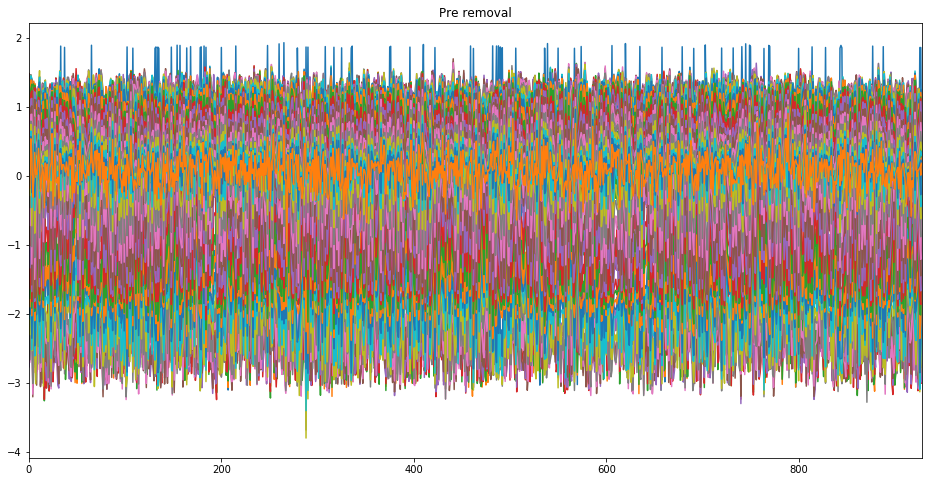

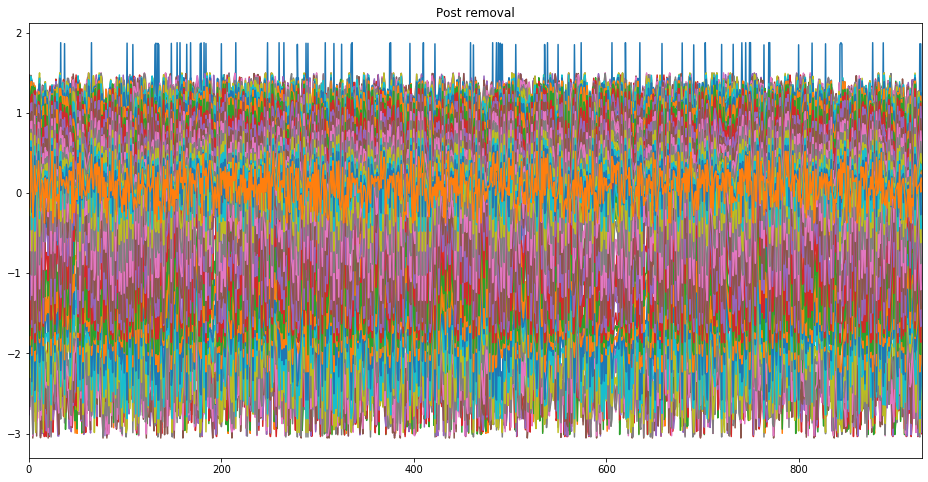

In [9]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

dataTrain_df = pd.DataFrame(dataTrain)
dataTrain_df.plot(legend=False, title="Pre removal");
dataTrain_clean = outlier_annihilation(dataTrain_df)
pd.DataFrame(dataTrain_clean).plot(legend=False, title="Post removal");

### Cleaning test data

Populating the interactive namespace from numpy and matplotlib


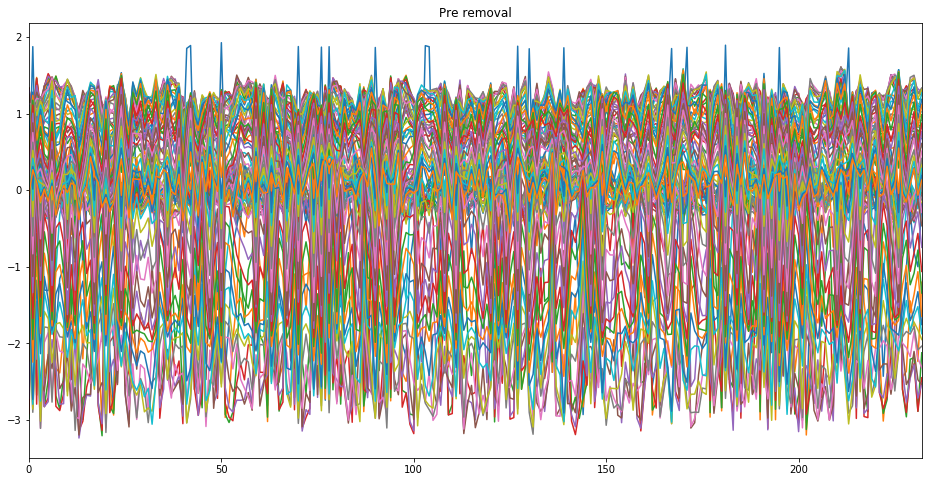

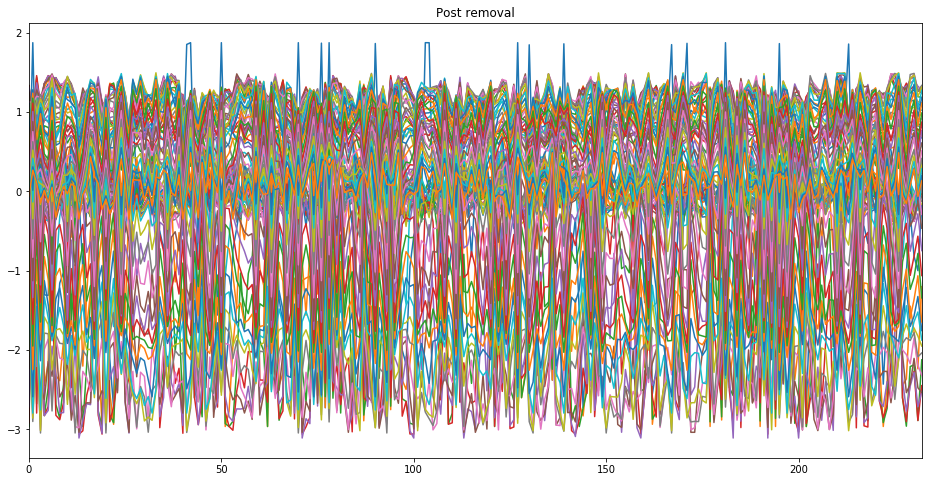

In [10]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

dataTest_df = pd.DataFrame(dataTest)
dataTest_df.plot(legend=False, title="Pre removal");
dataTest_clean = outlier_annihilation(dataTest_df)
pd.DataFrame(dataTest_clean).plot(legend=False, title="Post removal");

## Data description

In [11]:
N = dataTrain.shape[0]
Nval = dataTest.shape[0]
D = dataTrain.shape[1]
sl = D  # Time series sequence length
print('Train set observation: %s ' % (N+1))
print('Test set observation: %s ' % (Nval))
print('Dimension observation: %s ' % (D))

Train set observation: 930 
Test set observation: 233 
Dimension observation: 82 


## Valuate class number and min class

In [12]:
num_classes = len(np.unique(labelsTrain))
base = np.min(labelsTrain)  # Check if data is 0-based
if base != 0:
    labelsTrain -= base
    labelsTest -= base

print('We have %s classes, %s is the min class value' % (num_classes, base))

We have 2 classes, 1.0 is the min class value


In [13]:
import matplotlib.pyplot as plt
from collections import Counter

In [14]:
# %load -s plot_data ../scripts/plotUtilities.py 
def plot_data(data, classes, plot_row=10, save = False, name = 'tmp', adjust=True):
    counts = dict(Counter(classes))
    uniqueClasses = np.unique(classes)
    num_classes = len(uniqueClasses)
    f, axarr = plt.subplots(plot_row, num_classes)
    for selectedClass in uniqueClasses:  # Loops over classes, plot as columns
        selectedClass = int(selectedClass)
        ind = np.where(classes == selectedClass)
        ind_plot = np.random.choice(ind[0], size=plot_row)
        for n in range(plot_row):  # Loops over rows
            # Only shops axes for bottom row and left column
            if n == 0:
                axarr[n, selectedClass].set_title('Class %.0f (%.0f elements)' % (selectedClass + 1, counts[float(selectedClass)]))
            if n < counts[float(selectedClass)]:
                axarr[n, selectedClass].plot(data[ind_plot[n], :])

                if not n == plot_row - 1:
                    plt.setp([axarr[n, selectedClass].get_xticklabels()], visible=False)
                if not selectedClass == 0:
                    plt.setp([axarr[n, selectedClass].get_yticklabels()], visible=False)
    
    if adjust == True:
        f.subplots_adjust(hspace=0)  # No horizontal space between subplots
        f.subplots_adjust(wspace=0)  # No vertical space between subplots
    plt.show()

    if save:
        plt.savefig(name, format='png', dpi=1000)
        
    return


## Data class plot

Populating the interactive namespace from numpy and matplotlib


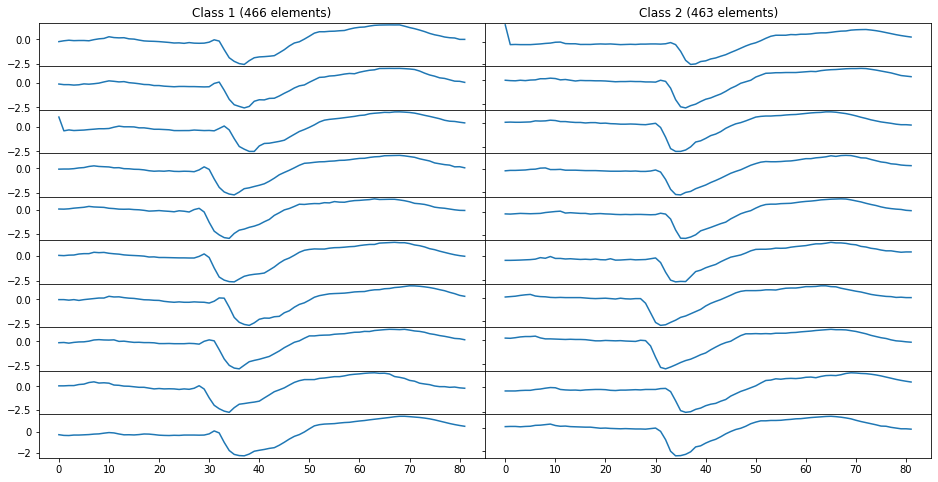

In [15]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)

plot_data(dataTrain, labelsTrain)
# plot_data(dataTrain, labelsTrain, 5, True, "Prova.eps")

# Training time

In [16]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_dtw

In [ ]:
dtw_distance_matrix = cdist_dtw(dataTrain_clean)
print(dtw_distance_matrix)

In [22]:
n_clusters = len(set(labelsTrain))
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="precomputed")
print("Model Configured to fit {} clusters".format(n_clusters))

Model Configured to fit 2 clusters


In [23]:
labels = model.fit_predict(dataTrain_clean)

1.925 --> 0.882 --> 0.858 --> 0.851 --> 0.848 --> 0.847 --> 0.847 --> 0.847 --> 0.847 --> 0.847 --> 0.847 --> 0.847 --> 0.847 --> 


# Clustering Evaluation

In [24]:
from tslearn.clustering import silhouette_score

## Silhouette score

In [26]:
ss = silhouette_score(dataTrain_clean,labels, metric='dtw')
print("Silhouette score", ss)

KeyboardInterrupt: 

## Davies Bouldin

In [46]:
# DB: Misura la separazione tra cluster, compiendo una media artimetica delle similarità tra coppie di cluster più simili
# , usandodi una misura di similarità tra cluster ad hoc che mette a rapporto la somma dei diametri 
# dei cluster (media distanza euclidea intra-cluster) e la distanza euclidea tra i rispettivi centroidi.
# Più tende a 0 meglio è. Fvorisce cluster densi e ben distanti 
# Più veloce di silhouette ma limitato alla distanza euclidea
db = davies_bouldin_score(actual_dataTest, clustering)
print("Davies Bouldin", db)

Davies Bouldin 0.8393323276676934


## Contingency Matrix

In [47]:
# Righe le label e colonne i cluster
cm = contingency_matrix(ground_labels, clustering)
print("Contingency matrix")
print(cm)

Contingency matrix
[[54 53]
 [44 41]]


## Purity

In [48]:
# Media tra tutti i cluster del numero di sample della label più presente di ciascun cluster.
# Da' una misura di quanto bene il clustering copre il labelling. Se è 1, il clustering ha coperto tutte le label
# , anche ricorrendo ad un numero di cluster maggiore delle classi
def purity(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm) 

pur = purity(ground_labels, clustering)
print("Purity: ", pur)

Purity:  0.5572916666666666


## Relative Purity

In [49]:
def rel_purity(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    labels_sum = np.sum(cm, axis=1)
    rm = np.zeros(cm.shape)
    for j in range(cm.shape[1]):
        for i in range(cm.shape[0]):
            rm[i][j] = cm[i][j] / labels_sum[i]
    #print("Relative Contingency Matrix")
    #print(rm)
    #print(np.max(rm, axis=0))
    
    max_indexes = np.argmax(rm, axis=0)
    #print(max_indexes)
    sum = 0
    for j in range(rm.shape[1]):
        sum += cm[max_indexes[j]][j]
    return sum / np.sum(cm)

rel_pur = rel_purity(ground_labels, clustering)
print("Relative Purity: ", rel_pur)

Relative Purity:  0.5052083333333334


## Adjusted rand index

In [50]:
# ARI: fix dell'RI, che mette a rapporto il numero di true (se due sample sono nello stesso cluster allora hanno la stessa label 
# + se due sample sono in cluster diversi allora hanno diversa label) sul numero totaale di coppie non ordinate di sample
# va bene quando si vuole un clustering molto fedele al labelling del dataset. Valida per dataset i cui sample appartengono a classi ben distanti.
# Immune al random labelling: https://scikit-learn.org/stable/auto_examples/cluster/plot_adjusted_for_chance_measures.html#sphx-glr-auto-examples-cluster-plot-adjusted-for-chance-measures-py
# Rule of thumb: Use ARI when the ground truth clustering has large equal sized clusters
ars = adjusted_rand_score(ground_labels, clustering)
print("Adjusted rand index: ", ars)

Adjusted rand index:  -0.005088118274706198


## Fowlkes-Mallows score

In [51]:
# FMS: Media geometrica di precision e recall pairwise
fms = fowlkes_mallows_score(ground_labels, clustering)
print("Fowlkes-Mallows score: ", fms)

Fowlkes-Mallows score:  0.4982404406436337


## Adjusted mutual information

In [52]:
# AMIS: fix del MIS, basata sull'entropia di Von Neuman, calcolata per le label e per i cluster
# Immune al random labelling
# Rule of thumb: Usa AMI when the ground truth clustering is unbalanced and there exist small clusters
amis = adjusted_mutual_info_score(ground_labels, clustering, average_method='arithmetic')
print("Adjusted mutual information: ", amis)

Adjusted mutual information:  -0.0036994600315099673


## V-Measure

In [53]:
# Media armonica di Homogeneity e Completeness. 
# Homogeneity: Quanto un cluster ha sample di una sola label
# Completeness: Quanto i sample di una label stanno in un solo cluster
# Entrambi basati sull'entropia di Von Neumann
# Debole al random clustering con alto numero di cluster. Non buono con dataset piccoli e/o grande numero di cluster
vm = v_measure_score(ground_labels, clustering)
print("V-Measure: ", vm)

V-Measure:  0.0001204805313871007
